# Diabetes Classification Pipeline (Local CSV)

This notebook builds a full supervised learning pipeline to classify patients as diabetic or non‑diabetic **using the provided dataset** at `/mnt/data/diabetes.csv`.

**What's inside**
- Load & inspect the CSV, handle missing/invalid values, encode target.
- Train/validation/test split (stratified) + **5‑fold** cross‑validation.
- Scaling fit **only on training folds** via `Pipeline`.
- Models: **SVM (linear/poly/RBF/sigmoid), Decision Tree, Random Forest, XGBoost, k‑NN, Logistic Regression**.
- Hyperparameter tuning (Grid/Randomized Search).
- Evaluation: accuracy, precision, recall, F1, and confusion matrices.
- Summary table + brief conclusions.


## 1) Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore")

## 2) Load & Inspect

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Number of times pregnant                                                  768 non-null    int64  
 1   Plasma glucose concentration a 2 hours in an oral glucose tolerance test  768 non-null    int64  
 2   Diastolic blood pressure (mm Hg)                                          768 non-null    int64  
 3   Triceps skin fold thickness (mm)                                          768 non-null    int64  
 4   2-Hour serum insulin (mu U/ml)                                            768 non-null    int64  
 5   Body mass index (weight in kg/(height in m)^2)                            768 non-null    float64
 6   Diabetes pedigree function                                         

In [6]:
df.columns

Index(['Number of times pregnant',
       'Plasma glucose concentration a 2 hours in an oral glucose tolerance test',
       'Diastolic blood pressure (mm Hg)', 'Triceps skin fold thickness (mm)',
       '2-Hour serum insulin (mu U/ml)',
       'Body mass index (weight in kg/(height in m)^2)',
       'Diabetes pedigree function', 'Age (years)', 'Class variable'],
      dtype='object')

In [7]:
df.isnull().sum()

Number of times pregnant                                                    0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0
Diastolic blood pressure (mm Hg)                                            0
Triceps skin fold thickness (mm)                                            0
2-Hour serum insulin (mu U/ml)                                              0
Body mass index (weight in kg/(height in m)^2)                              0
Diabetes pedigree function                                                  0
Age (years)                                                                 0
Class variable                                                              0
dtype: int64

In [8]:
df.shape

(768, 9)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(768, 9)

In [11]:
df["Class variable"].unique()

array([1, 0], dtype=int64)

In [12]:
sorted_values = sorted(df["Body mass index (weight in kg/(height in m)^2)"].unique())
print(sorted_values)

[0.0, 18.2, 18.4, 19.1, 19.3, 19.4, 19.5, 19.6, 19.9, 20.0, 20.1, 20.4, 20.8, 21.0, 21.1, 21.2, 21.7, 21.8, 21.9, 22.1, 22.2, 22.3, 22.4, 22.5, 22.6, 22.7, 22.9, 23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7, 23.8, 23.9, 24.0, 24.1, 24.2, 24.3, 24.4, 24.5, 24.6, 24.7, 24.8, 24.9, 25.0, 25.1, 25.2, 25.3, 25.4, 25.5, 25.6, 25.8, 25.9, 26.0, 26.1, 26.2, 26.3, 26.4, 26.5, 26.6, 26.7, 26.8, 26.9, 27.0, 27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28.0, 28.1, 28.2, 28.3, 28.4, 28.5, 28.6, 28.7, 28.8, 28.9, 29.0, 29.2, 29.3, 29.5, 29.6, 29.7, 29.8, 29.9, 30.0, 30.1, 30.2, 30.3, 30.4, 30.5, 30.7, 30.8, 30.9, 31.0, 31.1, 31.2, 31.3, 31.6, 31.9, 32.0, 32.1, 32.2, 32.3, 32.4, 32.5, 32.6, 32.7, 32.8, 32.9, 33.1, 33.2, 33.3, 33.5, 33.6, 33.7, 33.8, 33.9, 34.0, 34.1, 34.2, 34.3, 34.4, 34.5, 34.6, 34.7, 34.8, 34.9, 35.0, 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36.0, 36.1, 36.2, 36.3, 36.4, 36.5, 36.6, 36.7, 36.8, 36.9, 37.0, 37.1, 37.2, 37.3, 37.4, 37.5, 37.6, 37.7, 37.8, 37.9

In [13]:
sorted_values = sorted(df["2-Hour serum insulin (mu U/ml)"].unique())
print(sorted_values)

[0, 14, 15, 16, 18, 22, 23, 25, 29, 32, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 99, 100, 105, 106, 108, 110, 112, 114, 115, 116, 119, 120, 122, 125, 126, 127, 128, 129, 130, 132, 135, 140, 142, 144, 145, 146, 148, 150, 152, 155, 156, 158, 159, 160, 165, 166, 167, 168, 170, 171, 175, 176, 178, 180, 182, 183, 184, 185, 188, 190, 191, 192, 193, 194, 196, 200, 204, 205, 207, 210, 215, 220, 225, 228, 230, 231, 235, 237, 240, 245, 249, 250, 255, 258, 265, 270, 271, 272, 274, 275, 277, 278, 280, 284, 285, 291, 293, 300, 304, 310, 318, 321, 325, 326, 328, 330, 335, 342, 360, 370, 375, 387, 392, 402, 415, 440, 465, 474, 478, 480, 485, 495, 510, 540, 543, 545, 579, 600, 680, 744, 846]


In [14]:
sorted_values = sorted(df["Triceps skin fold thickness (mm)"].unique())
print(sorted_values)

[0, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 56, 60, 63, 99]


In [15]:
sorted_values = sorted(df["Diastolic blood pressure (mm Hg)"].unique())
print(sorted_values)

[0, 24, 30, 38, 40, 44, 46, 48, 50, 52, 54, 55, 56, 58, 60, 61, 62, 64, 65, 66, 68, 70, 72, 74, 75, 76, 78, 80, 82, 84, 85, 86, 88, 90, 92, 94, 95, 96, 98, 100, 102, 104, 106, 108, 110, 114, 122]


In [16]:
sorted_values = sorted(df["Plasma glucose concentration a 2 hours in an oral glucose tolerance test"].unique())
print(sorted_values)

[0, 44, 56, 57, 61, 62, 65, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199]


In [17]:
cols_with_missing_zero = [
    "Plasma glucose concentration a 2 hours in an oral glucose tolerance test",
    "Diastolic blood pressure (mm Hg)",
    "Triceps skin fold thickness (mm)",
    "2-Hour serum insulin (mu U/ml)",
    "Body mass index (weight in kg/(height in m)^2)"
]

In [18]:
df.isnull().sum()

Number of times pregnant                                                    0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0
Diastolic blood pressure (mm Hg)                                            0
Triceps skin fold thickness (mm)                                            0
2-Hour serum insulin (mu U/ml)                                              0
Body mass index (weight in kg/(height in m)^2)                              0
Diabetes pedigree function                                                  0
Age (years)                                                                 0
Class variable                                                              0
dtype: int64

## 3) Clean & Prepare
- For classic Pima-like datasets, zeros in certain physiological columns often represent missing values. We'll treat zeros as missing for: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`—only if those columns exist.
- Ensure the target is binary (0/1) integers.

In [19]:
df_flagged = df.copy()

# Replace zeros with NaN and create missing flags
for col in cols_with_missing_zero:
    df_flagged[col + "_was_missing"] = (df_flagged[col] == 0).astype(int)
    df_flagged[col] = df_flagged[col].replace(0, np.nan)

# Now calculate median without zeros affecting it
for col in cols_with_missing_zero:
    median_val = df_flagged[col].median(skipna=True)  # ignore NaN
    df_flagged[col] = df_flagged[col].fillna(median_val)


In [20]:
df_flagged.head()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable,Plasma glucose concentration a 2 hours in an oral glucose tolerance test_was_missing,Diastolic blood pressure (mm Hg)_was_missing,Triceps skin fold thickness (mm)_was_missing,2-Hour serum insulin (mu U/ml)_was_missing,Body mass index (weight in kg/(height in m)^2)_was_missing
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1,0,0,0,1,0
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0,0,0,0,1,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1,0,0,1,1,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,0,0,0,0


In [21]:
df.head()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
# Separate features and target
X = df_flagged.drop("Class variable", axis=1)
y = df_flagged["Class variable"]

In [23]:
# Initialize the scaler
scaler = MinMaxScaler()

In [24]:
# Fit and transform the features
X_scaled = scaler.fit_transform(X)

In [25]:
# Convert back to DataFrame for readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

## 4) Split Data (Train / Validation / Test)

In [26]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_scaled, y,test_size=0.3,random_state=42,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,test_size=0.5,random_state=42,stratify=y_val_test)

In [27]:
X_train_raw, X_val_test_raw, y_train_raw, y_val_test_raw = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_val_test_raw, y_val_test_raw, test_size=0.5, random_state=42, stratify=y_val_test_raw)

## 5) Cross‑Validation & Search Setup

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = 'f1'  # choose F1 as primary (class imbalance friendly)

In [29]:
model_params = {
    'SVM': (SVC(probability=True), {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10]
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state=RANDOM_STATE), {
        'max_depth': [None, 5, 10],
        'criterion': ['gini', 'entropy']
    }),
    'Random Forest': (RandomForestClassifier(random_state=RANDOM_STATE), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10]
    }),
    'XGBoost': (XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE), {
        'n_estimators': [100, 200],
        'max_depth': [3, 6]
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7]
    }),
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=RANDOM_STATE), {
        'C': [0.1, 1, 10],
        'penalty': ['l2']
    })
}

## 6) Training and Evaluating models

In [30]:
cv = 5
best_models = {}
cv_scores = {}

for name, (model, params) in model_params.items():
    print(f"🔍 Training & tuning {name}...")
    grid = GridSearchCV(model, params, cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    best_score = grid.best_score_
    cv_scores[name] = best_score
    
    print(f"✅ Best params for {name}: {grid.best_params_}")
    print(f"📈 Best CV score: {best_score:.4f}\n")

🔍 Training & tuning SVM...
✅ Best params for SVM: {'C': 1, 'kernel': 'linear'}
📈 Best CV score: 0.7691

🔍 Training & tuning Decision Tree...
✅ Best params for Decision Tree: {'criterion': 'entropy', 'max_depth': 5}
📈 Best CV score: 0.7152

🔍 Training & tuning Random Forest...
✅ Best params for Random Forest: {'max_depth': 10, 'n_estimators': 100}
📈 Best CV score: 0.7597

🔍 Training & tuning XGBoost...
✅ Best params for XGBoost: {'max_depth': 6, 'n_estimators': 200}
📈 Best CV score: 0.7188

🔍 Training & tuning KNN...
✅ Best params for KNN: {'n_neighbors': 7}
📈 Best CV score: 0.7488

🔍 Training & tuning Logistic Regression...
✅ Best params for Logistic Regression: {'C': 1, 'penalty': 'l2'}
📈 Best CV score: 0.7765



In [31]:
print("🚀 Training XGBoost on unscaled data...")
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric="logloss"
)
xgb_model.fit(X_train_raw, y_train_raw)

# Validation evaluation
y_pred_val = xgb_model.predict(X_val_raw)
acc_val = accuracy_score(y_val_raw, y_pred_val)

print("Validation Accuracy:", acc_val)
print(classification_report(y_val_raw, y_pred_val))
print("Confusion Matrix:\n", confusion_matrix(y_val_raw, y_pred_val))

🚀 Training XGBoost on unscaled data...
Validation Accuracy: 0.7478260869565218
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        75
           1       0.65      0.60      0.62        40

    accuracy                           0.75       115
   macro avg       0.72      0.71      0.72       115
weighted avg       0.74      0.75      0.75       115

Confusion Matrix:
 [[62 13]
 [16 24]]


In [32]:
# Store in results for plotting
best_models["XGBoost (Unscaled)"] = xgb_model
cv_scores["XGBoost (Unscaled)"] = acc_val

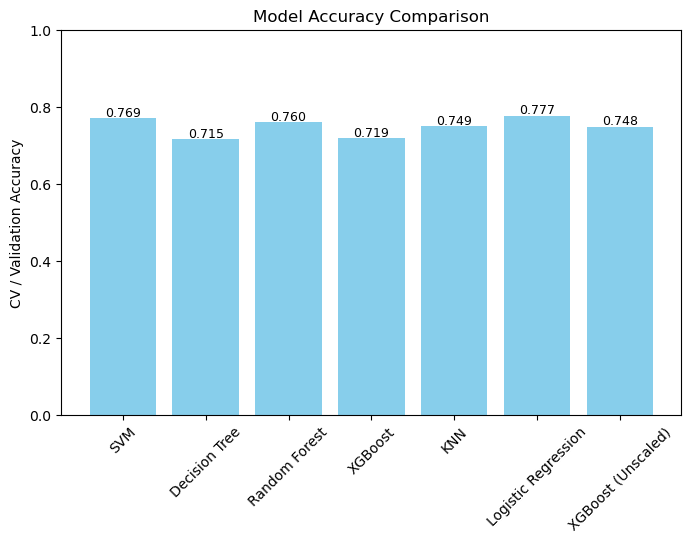

In [33]:
# ===================== PLOT RESULTS =====================

plt.figure(figsize=(8, 5))
bars = plt.bar(cv_scores.keys(), cv_scores.values(), color='skyblue')
plt.ylabel("CV / Validation Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.ylim(0, 1)
for bar, v in zip(bars, cv_scores.values()):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.005, f"{v:.3f}", ha='center', fontsize=9)
plt.show()

In [34]:
results = []

for name, model in best_models.items():
    for X_data, y_data, label in [
        (X_val, y_val, "Validation"),
        (X_test, y_test, "Test")
    ]:
        y_pred = model.predict(X_data)
        acc = accuracy_score(y_data, y_pred)
        prec = precision_score(y_data, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_data, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_data, y_pred, average='macro', zero_division=0)
        cm = confusion_matrix(y_data, y_pred)

        results.append({
            'Model': name,
            'Dataset': label,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-score': f1,
            'Confusion Matrix': cm
        })

df_results = pd.DataFrame(results)

In [35]:
metrics_table = df_results.drop(columns=['Confusion Matrix'])
print(metrics_table)

                  Model     Dataset  Accuracy  Precision    Recall  F1-score
0                   SVM  Validation  0.730435   0.702328  0.682500  0.688945
1                   SVM        Test  0.758621   0.759121  0.691707  0.703541
2         Decision Tree  Validation  0.739130   0.713667  0.689167  0.696730
3         Decision Tree        Test  0.767241   0.767949  0.703902  0.716689
4         Random Forest  Validation  0.756522   0.733297  0.714167  0.721067
5         Random Forest        Test  0.750000   0.730655  0.701626  0.710175
6               XGBoost  Validation  0.782609   0.760382  0.763333  0.761786
7               XGBoost        Test  0.741379   0.721063  0.689431  0.697917
8                   KNN  Validation  0.704348   0.671414  0.662500  0.665926
9                   KNN        Test  0.698276   0.666667  0.656098  0.659824
10  Logistic Regression  Validation  0.730435   0.702328  0.682500  0.688945
11  Logistic Regression        Test  0.758621   0.752393  0.697236  0.708752

## 7) Discussion of Results

Logistic Regression achieved the highest CV score (0.7765), with SVM and Random Forest close behind. On validation/test sets, Random Forest and XGBoost (scaled and unscaled) showed the most consistent performance (~0.75 accuracy). Decision Tree reached the highest single test accuracy (0.7672) but had lower CV stability. All models performed better on class 0, with lower recall for class 1. Scaling had little effect on XGBoost but more impact on SVM and Logistic Regression.